# Bayesian RFI Mitigation - Example
This is a simple script showing how to integrate a likelihood capable of correcting for RFI into a Bayesian data analysis pipeline. 

First, generate some mock data.

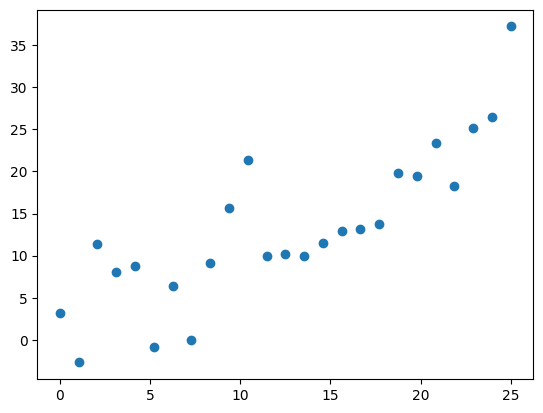

In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 25
x = np.linspace(0, 25, N)
m = 1
c = 1
sig = 5
y = m * x + c + np.random.randn(N) * sig
plt.plot(x, y, 'o')

Add some RFI

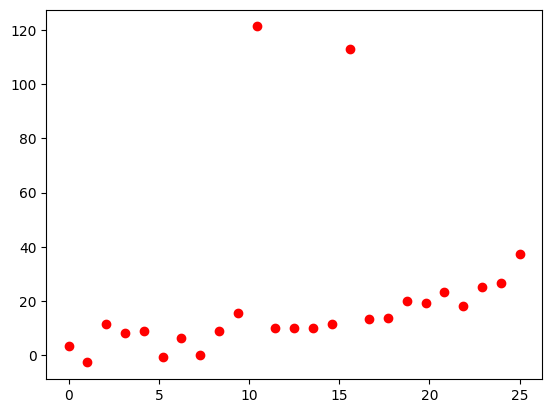

In [2]:
y[10] += 100
y[15] += 100
plt.plot(x, y, 'ro')

Now, define a traditional likelihood function and fit the data without modeling the RFI.

In [3]:
def likelihood(theta):
    m=theta[0]
    c=theta[1]
    sig=theta[2]
    y_=m * x + c
    return (-(y_-y)**2/sig**2/2 - np.log(2*np.pi*sig**2)/2).sum(), []

Now, we'll define a likelihood function that can correct for RFI.
 Note the difference between the two likelihoods. Notice the condition imposed on the likelihood by `emax'.

In [4]:
def rfi_corrected_likelihood(theta):
    m=theta[0]
    c=theta[1]
    sig=theta[2]
    y_= m * x + c
    logL=-(y_-y)**2/sig**2/2 - np.log(2*np.pi*sig**2)/2 + np.log(1-p)
    emax = logL > logp - np.log(delta)
    logPmax=np.where(emax, logL, logp - np.log(delta)).sum()
    return logPmax, []

Definte a prior. Notice that the prior range which encapsulates the full range of possible values from the data as defined by delta.

In [5]:
from pypolychord.priors import UniformPrior

def prior(hypercube):
    theta = np.zeros_like(hypercube)
    theta[0]=UniformPrior(-delta/(np.max(x)-np.min(x)), delta/(np.max(x)-np.min(x)))(hypercube[1])  # m
    theta[1] = UniformPrior(-delta, delta)(hypercube[0])  # c
    theta[2]=UniformPrior(0, delta)(hypercube[2])  # sig
    return theta

Set $p$ (the probability thresholding term) and $\Delta$ (the length scale in units of data)

In [6]:
delta = np.max(y)
logp = -2.5
p = np.exp(logp)

Fit with a Bayesian numerical solver. We use the Nested Sampler Polychord but any others will also work.
 Polychord settings.

In [7]:
import pypolychord
from pypolychord.settings import PolyChordSettings

nDims=3
nDerived=0
settings=PolyChordSettings(nDims, nDerived)
settings.nlive=200
settings.read_resume=False


We first fit the data using the traditional likelihood

In [8]:
settings.file_root='rfi_nocorr'
output=pypolychord.run_polychord(
likelihood, nDims, nDerived, settings, prior)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.20.1
  release: 1st June 2021
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       3
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/rfi_nocorr.resume

generating live points


all live points generated

Speed  1 =  0.795E-04 seconds
number of repeats:           15
started sampling

_________________
lives      | 200 |
phantoms   |1827 |
posteriors | 201 |
equals     |  20 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 201
nposterior =                 201
nequals    =                  24
nlike      =                5014
<nlike>    =          24.07   (           1.60 per slice )
log(Z)     =        

Process the results using anesthetic. Again, any other chains evaluator could be used here.

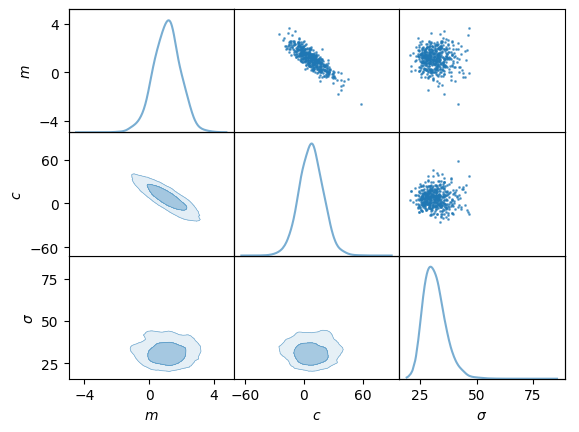

In [9]:
from anesthetic import NestedSamples
norfi_nocorr=NestedSamples(
    root = './chains/rfi_nocorr', columns = ['$m$', '$c$', r'$\sigma$'])
fig, ax=norfi_nocorr.plot_2d(['$m$', '$c$', r'$\sigma$'],
                               label = 'RFI No Correction', alpha = 0.6)

Notice that $\sigma$ is estimated completely wrong, and the confidence in the other parameters is low.

Fit the data, this time using the correcting likelihood

In [10]:
settings.file_root='rfi_corr'
output=pypolychord.run_polychord(
    rfi_corrected_likelihood, nDims, nDerived, settings, prior)

Compare the results,

/home/sam/.local/lib/python3.10/site-packages/anesthetic-2.0.0b12-py3.10.egg/anesthetic/samples.py:750: RuntimeWarning: 1 out of 3943 samples have logL <= logL_birth,
1 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


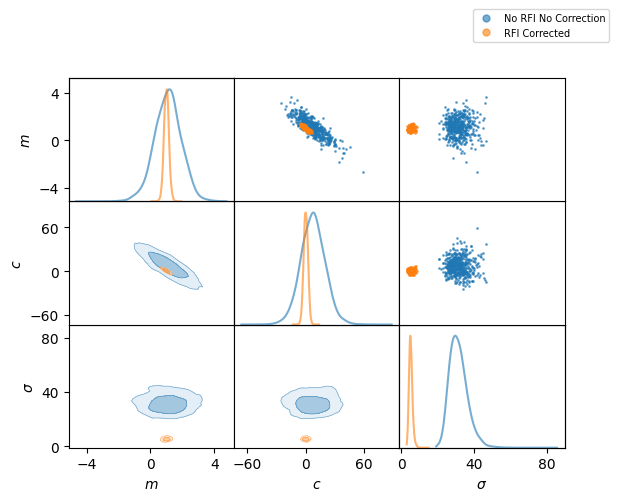

In [11]:
from anesthetic import NestedSamples
rfi_corr=NestedSamples(
    root = './chains/rfi_corr', columns = ['$m$', '$c$', r'$\sigma$'])
fig, ax=norfi_nocorr.plot_2d(['$m$', '$c$', r'$\sigma$'],
                               label = 'No RFI No Correction', alpha = 0.6)
rfi_corr.plot_2d(ax, label = 'RFI Corrected', alpha = 0.6)
plt.legend(loc='upper right', markerscale=5,
           bbox_to_anchor=(1.3, 1.6), fontsize=7)

# Key Point

The vast majority of this example makes up the general 'pipeline' for simulating and analysing the data. Only three lines of code are modified (inside rfi_corrected_likelihood) to impliment the RFI correction.